# Artificial Neural Networks and Deep Learning

---

## Homework 2


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


import matplotlib.pyplot as plt
%matplotlib inline

import hashlib
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
## U-net imports

import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

## Data Exploration Functions


In [ ]:
def plot_image_mask_pairs(X, y, num_pairs=5):
    num_samples = min(num_pairs, len(X))
    plt.figure(figsize=(10, 4 * num_samples))

    random_indices = np.random.choice(len(X), num_samples, replace=False)
    for idx, i in enumerate(random_indices):
        plt.subplot(num_samples, 2, 2 * idx + 1)
        plt.imshow(X[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * idx + 2)
        plt.imshow(y[i], cmap='nipy_spectral', vmin=0, vmax=4)  # Standardize the color scaling
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

def compute_class_distribution(y_train, num_classes=5):
    """
    Compute the percentage of pixels belonging to each class in the dataset.

    Parameters:
    - y_train (numpy array): Array of shape (num_images, height, width) containing the label masks.
    - num_classes (int): The number of classes in the dataset (default is 5).

    Returns:
    - percentages (list): A list of percentages corresponding to each class.
    """
    # Flatten the masks to count pixel values across all images
    flattened_labels = y_train.flatten()

    # Total number of pixels
    total_pixels = flattened_labels.size

    # Compute the percentage for each class
    percentages = [(flattened_labels == i).sum() / total_pixels * 100 for i in range(num_classes)]

    return percentages

In [ ]:
import numpy as np

def flip_dataset(X_train, y_train):
    """
    Augments the dataset by adding horizontally and vertically flipped versions of
    the images and their corresponding masks.

    Args:
        X_train (numpy.ndarray): Training images of shape (n_samples, 64, 128).
        y_train (numpy.ndarray): Corresponding masks of shape (n_samples, 64, 128).

    Returns:
        augmented_X (numpy.ndarray): Augmented training images.
        augmented_y (numpy.ndarray): Augmented training masks.
    """
    # Horizontal flipping
    X_h_flip = np.flip(X_train, axis=2)  # Flip along width (horizontal axis)
    y_h_flip = np.flip(y_train, axis=2)

    # Combine original and horizontally flipped data
    X_combined = np.concatenate((X_train, X_h_flip), axis=0)
    y_combined = np.concatenate((y_train, y_h_flip), axis=0)

    # Vertical flipping
    X_v_flip = np.flip(X_combined, axis=1)  # Flip along height (vertical axis)
    y_v_flip = np.flip(y_combined, axis=1)

    # Combine with vertically flipped data
    augmented_X = np.concatenate((X_combined, X_v_flip), axis=0)
    augmented_y = np.concatenate((y_combined, y_v_flip), axis=0)

    return augmented_X, augmented_y


## Data Cleanup Functions


In [ ]:
def find_duplicate_masks(labels):
    hashes = {}
    duplicates = {}

    for i, mask in enumerate(labels):
        mask_flat = mask.tobytes()
        mask_hash = hashlib.md5(mask_flat).hexdigest()

        if mask_hash in hashes:
            first_index = hashes[mask_hash]
            if first_index not in duplicates:
                duplicates[first_index] = []  # Initialize the list for this first index
            duplicates[first_index].append(i)  # Add the duplicate index
        else:
            hashes[mask_hash] = i  # Store the first occurrence of this hash

    return duplicates

In [ ]:
def remove_alien_elements(input_dict, keys_to_remove):
    result = {}
    for key, value in input_dict.items():
        if key not in keys_to_remove:
            result[key] = value
    return result

In [ ]:
pip install albumentations opencv-python

In [ ]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations.transforms import *
import cv2
from albumentations import Compose


import numpy as np
def augment_image_and_mask(image, mask, augmentations):
    """
    Apply the same augmentations to an image and its corresponding mask.

    Args:
        image (np.ndarray): The input image.
        mask (np.ndarray): The corresponding mask.
        augmentations: Albumentations augmentation pipeline.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented image and mask.
    """
    data = augmentations(image=image, mask=mask)
    return data["image"], data["mask"]

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def augment_dataset(X_train, y_train, augmentations):
    """
    Augment the dataset by applying transformations, including horizontal and vertical flips.

    Args:
        X_train (np.ndarray): Array of input images of shape (N, 64, 128).
        y_train (np.ndarray): Array of masks of shape (N, 64, 128).
        augmentations: Albumentations augmentation pipeline.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented image and mask arrays.
    """
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(X_train, y_train):
        # Original
        augmented_images.append(img)
        augmented_masks.append(mask)

        # Horizontal Flip
        img_hf, mask_hf = augment_image_and_mask(img, mask, A.Compose([A.HorizontalFlip(p=1)]))
        augmented_images.append(img_hf)
        augmented_masks.append(mask_hf)

        # Vertical Flip
        img_vf, mask_vf = augment_image_and_mask(img, mask, A.Compose([A.VerticalFlip(p=1)]))
        augmented_images.append(img_vf)
        augmented_masks.append(mask_vf)

        # Combined (Horizontal + Vertical Flip)
        img_hvf, mask_hvf = augment_image_and_mask(img_hf, mask_hf, A.Compose([A.VerticalFlip(p=1)]))
        augmented_images.append(img_hvf)
        augmented_masks.append(mask_hvf)

    # Convert lists to arrays
    return np.array(augmented_images), np.array(augmented_masks)


## Training Functions

In [ ]:
import keras
import tensorflow as tf
from keras.metrics import MeanIoU
from keras.saving import register_keras_serializable

@keras.saving.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, ignore_class=None, name="mean_iou", dtype=None, **kwargs):
        # Pass only recognized arguments to the parent class
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs)

        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0 (background)
        self.labels_to_exclude = labels_to_exclude
        self.ignore_class = ignore_class  # Explicitly handle the ignore_class

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        # Extend the parent class's get_config to include custom arguments
        config = super(MeanIntersectionOverUnion, self).get_config()
        config.update({
            "labels_to_exclude": self.labels_to_exclude,
            "ignore_class": self.ignore_class,
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Ensure the custom config can be deserialized
        return cls(**config)


In [ ]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    print(f"Loading image from {image_path}")
    print(f"Loading label from {label_path}")
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure 1 channel, greyscale
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [ ]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            num_classes = 5 #had to do it
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
#Creating a colour map
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """

    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
#Finding and removing duplicates
duplicates = find_duplicate_masks(y_train)

#After manual inspection, the first alien image appears at index 62:
alien_image_indices = duplicates[62]
alien_image_indices.append(62)

# Step 3: Create a dictionary of all masks
input_dict = {index: y_train[index] for index in range(len(y_train))}

no_aliens_map = remove_alien_elements(input_dict, alien_image_indices)

remaining_indices = [i for i in range(len(y_train)) if i not in alien_image_indices]

X_train = X_train[remaining_indices]
y_train = y_train[remaining_indices]

print(f"Total masks before removal: {len(input_dict)}")
print(f"Total masks after removal: {len(no_aliens_map)}")

Total masks before removal: 2615
Total masks after removal: 2505


In [ ]:
#Split a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.7, random_state=seed)

In [ ]:
# Adding flipped versions of images
X_train, y_train = flip_dataset(X_train, y_train)

In [ ]:
augmentations = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.5625, scale_limit=0.1, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=7, p=0.4),
        A.MedianBlur(blur_limit=7, p=0.4),
        A.Blur(blur_limit=7, p=0.4)
    ], p=0.5),
    A.Resize(64, 128, always_apply=True),  # Ensures all outputs are the correct shape
])

# Apply the augmentations
X_train, y_train = augment_dataset(X_train, y_train, augmentations)

## 🛠️ Train and Save the Model

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

#

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Defining constants

batch_size = 64
num_epochs = 150
learning_rate = 0.001
patience = 15

### Define Model

In [ ]:
def res_conv_block(x, filter_size, size):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

In [ ]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def gating_signal(input, out_size):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


In [ ]:
def senet_block(input, filters, kernel_size=3, activation='relu', stack=2, name=''):
    for s in range(stack):
        # Main concolutional part
        x = tfkl.Conv2D(filters, kernel_size, padding='same', use_bias=False, name=f'{name}_conv_{s}')(input)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_activation_{s}')(x)

        # Squeeze-and-excitation module
        channels = x.shape[-1]
        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)
        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1,1,channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x,se])

        return x

In [ ]:
def repeat_elem(tensor, rep):

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [ ]:
def Attention_ResUNet(input_shape=(64, 128, 1), NUM_CLASSES=5):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2

    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3

    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4

    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only

    conv_8 = senet_block(pool_8, 16*FILTER_NUM, name='bottleneck')

    # Upsampling layers

    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

### Building model

In [ ]:
model = Attention_ResUNet(input_shape=input_shape, NUM_CLASSES=num_classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation_1[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 64)  │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 64, 128, 64)  │          128 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 64)  │            0 │ conv2d_3[0][0],     │    -    │
│                        │                      │              │ activation_2[0][0]  │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_3           │ (None, 64, 128, 64)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_3[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_4 (Conv2D)    

 Total params: 35,517,597 (135.49 MB)

 Trainable params: 35,500,179 (135.42 MB)

 Non-trainable params: 17,418 (68.04 KB)

## Compile Model

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

print("Model compiled!")

Compiling model...
Model compiled!


### Setup Callbacks

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor= "accuracy",
    mode='max',
    patience=patience,
    restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor= "accuracy",
    mode='max',
    factor=0.1,
    patience=8,
    min_lr=1e-4
)

viz_callback = VizCallback(X_val[10], y_val[10])

### Train the Model

Epoch 1/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5561 - loss: 1.2019 - mean_iou: 0.2782

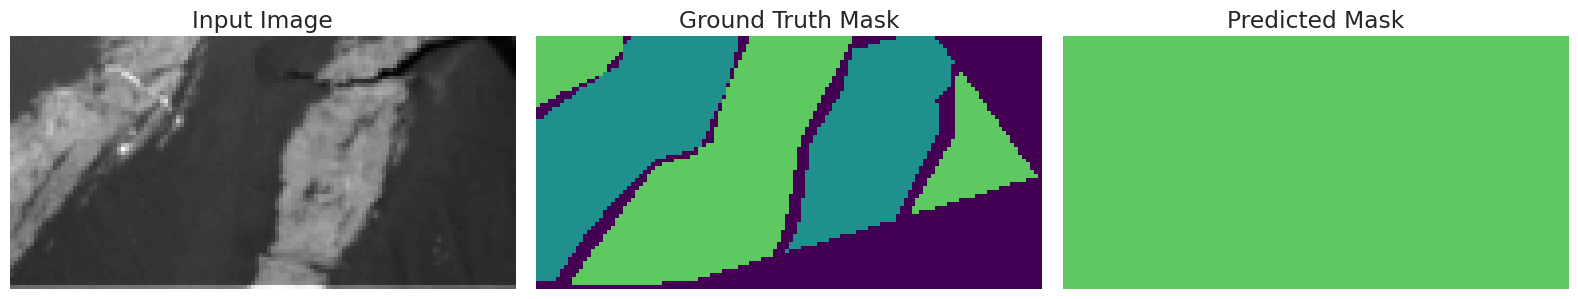

376/376 ━━━━━━━━━━━━━━━━━━━━ 165s 233ms/step - accuracy: 0.5563 - loss: 1.2014 - mean_iou: 0.2783 - val_accuracy: 0.2241 - val_loss: 3.0269 - val_mean_iou: 0.0734 - learning_rate: 0.0010
Epoch 2/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.7229 - loss: 0.8050 - mean_iou: 0.4142 - val_accuracy: 0.5390 - val_loss: 1.2069 - val_mean_iou: 0.2525 - learning_rate: 0.0010
Epoch 3/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.7550 - loss: 0.6957 - mean_iou: 0.4399 - val_accuracy: 0.7018 - val_loss: 0.8188 - val_mean_iou: 0.4250 - learning_rate: 0.0010
Epoch 4/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.7862 - loss: 0.6043 - mean_iou: 0.4665 - val_accuracy: 0.7464 - val_loss: 0.7090 - val_mean_iou: 0.4575 - learning_rate: 0.0010
Epoch 5/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8153 - loss: 0.5250 - mean_iou: 0.4890 - val_accuracy: 0.5776 - val_loss: 1.2603 - val_mean_iou: 0.2991 - learning_rate: 0.0010
Epoch 6/150
375/376 ━━━━━

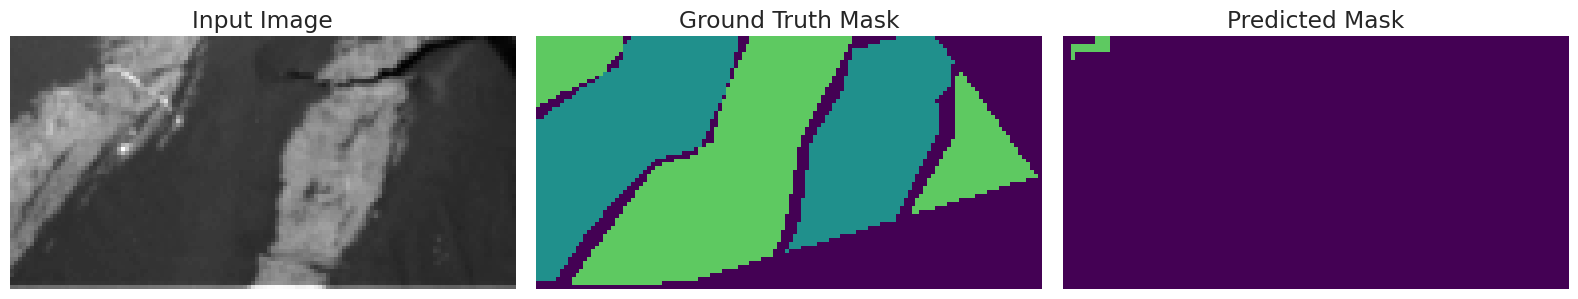

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8355 - loss: 0.4682 - mean_iou: 0.5015 - val_accuracy: 0.6767 - val_loss: 0.9877 - val_mean_iou: 0.3637 - learning_rate: 0.0010
Epoch 7/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8669 - loss: 0.3831 - mean_iou: 0.5254 - val_accuracy: 0.5298 - val_loss: 1.3100 - val_mean_iou: 0.2308 - learning_rate: 0.0010
Epoch 8/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8757 - loss: 0.3585 - mean_iou: 0.5254 - val_accuracy: 0.7297 - val_loss: 0.8121 - val_mean_iou: 0.4407 - learning_rate: 0.0010
Epoch 9/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9112 - loss: 0.2633 - mean_iou: 0.5539 - val_accuracy: 0.7087 - val_loss: 0.9423 - val_mean_iou: 0.4129 - learning_rate: 0.0010
Epoch 10/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9178 - loss: 0.2419 - mean_iou: 0.5560 - val_accuracy: 0.7452 - val_loss: 0.7679 - val_mean_iou: 0.4527 - learning_rate: 0.0010
Epoch 11/150
375/376 ━━━━━

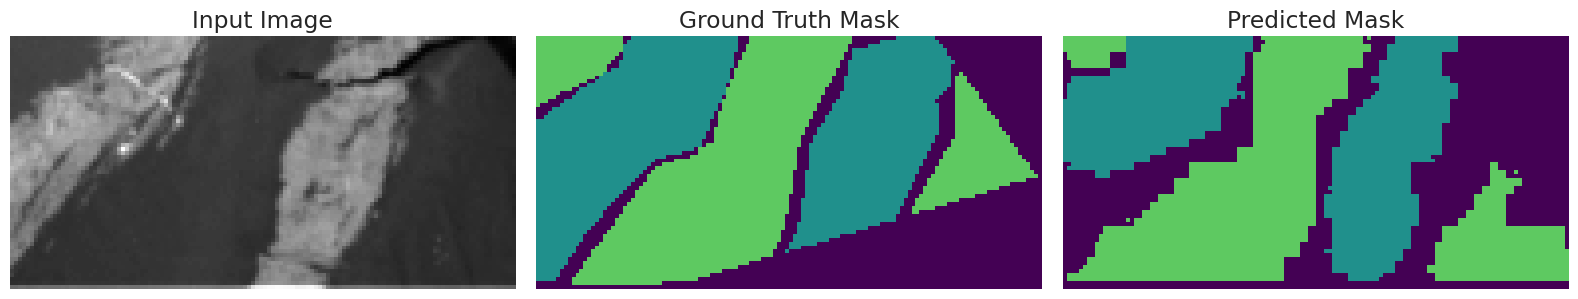

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9456 - loss: 0.1636 - mean_iou: 0.5821 - val_accuracy: 0.7213 - val_loss: 1.0306 - val_mean_iou: 0.4219 - learning_rate: 0.0010
Epoch 12/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9501 - loss: 0.1480 - mean_iou: 0.6191 - val_accuracy: 0.4930 - val_loss: 3.3410 - val_mean_iou: 0.2302 - learning_rate: 0.0010
Epoch 13/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9414 - loss: 0.1677 - mean_iou: 0.6479 - val_accuracy: 0.7595 - val_loss: 0.8506 - val_mean_iou: 0.4664 - learning_rate: 0.0010
Epoch 14/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9689 - loss: 0.0885 - mean_iou: 0.7227 - val_accuracy: 0.7599 - val_loss: 0.9611 - val_mean_iou: 0.4662 - learning_rate: 0.0010
Epoch 15/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9742 - loss: 0.0732 - mean_iou: 0.7387 - val_accuracy: 0.7592 - val_loss: 1.0330 - val_mean_iou: 0.4607 - learning_rate: 0.0010
Epoch 16/150
375/376 ━━

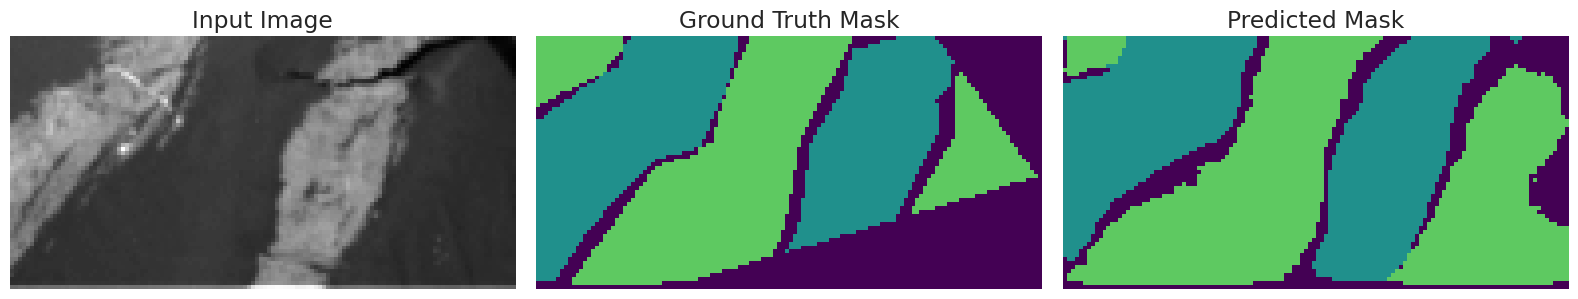

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9776 - loss: 0.0623 - mean_iou: 0.7424 - val_accuracy: 0.7565 - val_loss: 1.1304 - val_mean_iou: 0.4638 - learning_rate: 0.0010
Epoch 17/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9806 - loss: 0.0538 - mean_iou: 0.7550 - val_accuracy: 0.7577 - val_loss: 1.1335 - val_mean_iou: 0.4645 - learning_rate: 0.0010
Epoch 18/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9538 - loss: 0.1301 - mean_iou: 0.7080 - val_accuracy: 0.6802 - val_loss: 1.1445 - val_mean_iou: 0.4010 - learning_rate: 0.0010
Epoch 19/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9721 - loss: 0.0769 - mean_iou: 0.7406 - val_accuracy: 0.7616 - val_loss: 1.0242 - val_mean_iou: 0.4735 - learning_rate: 0.0010
Epoch 20/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9783 - loss: 0.0610 - mean_iou: 0.7474 - val_accuracy: 0.7614 - val_loss: 1.0740 - val_mean_iou: 0.4699 - learning_rate: 0.0010
Epoch 21/150
375/376 ━━

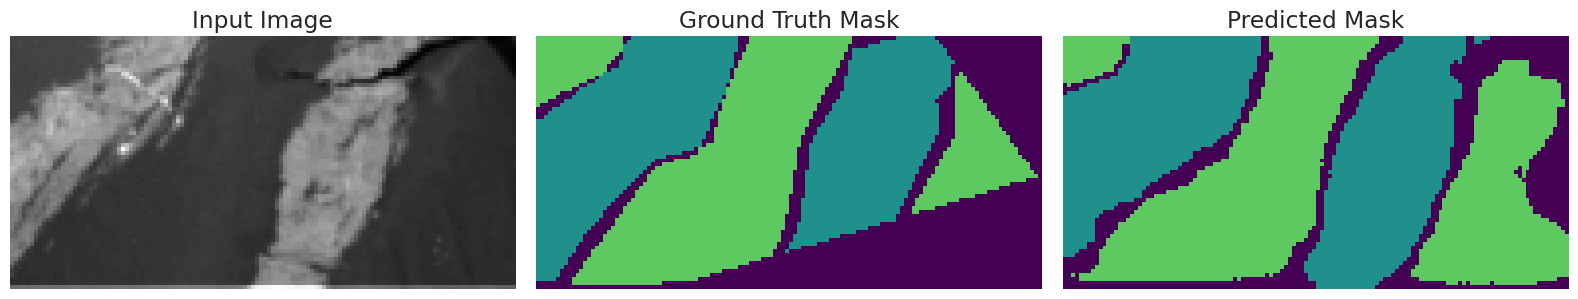

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9862 - loss: 0.0375 - mean_iou: 0.7675 - val_accuracy: 0.7592 - val_loss: 1.1610 - val_mean_iou: 0.4678 - learning_rate: 0.0010
Epoch 22/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9885 - loss: 0.0312 - mean_iou: 0.7741 - val_accuracy: 0.7585 - val_loss: 1.2299 - val_mean_iou: 0.4640 - learning_rate: 0.0010
Epoch 23/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9890 - loss: 0.0296 - mean_iou: 0.7729 - val_accuracy: 0.7592 - val_loss: 1.2781 - val_mean_iou: 0.4652 - learning_rate: 0.0010
Epoch 24/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9895 - loss: 0.0278 - mean_iou: 0.7755 - val_accuracy: 0.7571 - val_loss: 1.3020 - val_mean_iou: 0.4613 - learning_rate: 0.0010
Epoch 25/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9895 - loss: 0.0275 - mean_iou: 0.7773 - val_accuracy: 0.7607 - val_loss: 1.3545 - val_mean_iou: 0.4759 - learning_rate: 0.0010
Epoch 26/150
375/376 ━━

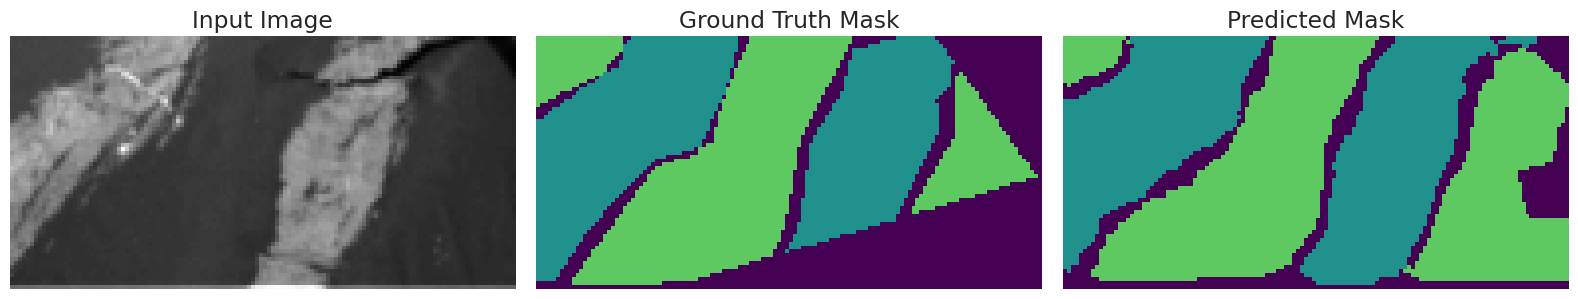

376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9901 - loss: 0.0260 - mean_iou: 0.7783 - val_accuracy: 0.7625 - val_loss: 1.3694 - val_mean_iou: 0.4722 - learning_rate: 0.0010
Epoch 27/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9906 - loss: 0.0246 - mean_iou: 0.7786 - val_accuracy: 0.7610 - val_loss: 1.4193 - val_mean_iou: 0.4746 - learning_rate: 0.0010
Epoch 28/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9578 - loss: 0.1214 - mean_iou: 0.7113 - val_accuracy: 0.6835 - val_loss: 1.0216 - val_mean_iou: 0.3869 - learning_rate: 0.0010
Epoch 29/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9645 - loss: 0.0994 - mean_iou: 0.7362 - val_accuracy: 0.7620 - val_loss: 1.0887 - val_mean_iou: 0.4728 - learning_rate: 0.0010
Epoch 30/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9903 - loss: 0.0255 - mean_iou: 0.7796 - val_accuracy: 0.7616 - val_loss: 1.3038 - val_mean_iou: 0.4711 - learning_rate: 0.0010
Epoch 31/150
375/376 ━━

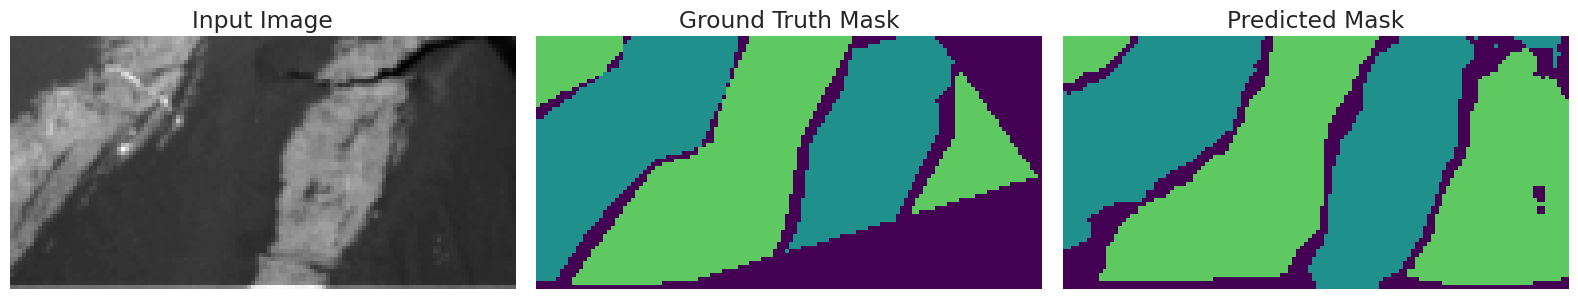

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.9935 - loss: 0.0174 - mean_iou: 0.7845 - val_accuracy: 0.7613 - val_loss: 1.4254 - val_mean_iou: 0.4691 - learning_rate: 0.0010
Epoch 32/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9945 - loss: 0.0149 - mean_iou: 0.7851 - val_accuracy: 0.7627 - val_loss: 1.4736 - val_mean_iou: 0.4707 - learning_rate: 0.0010
Epoch 33/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9947 - loss: 0.0142 - mean_iou: 0.7873 - val_accuracy: 0.7611 - val_loss: 1.4946 - val_mean_iou: 0.4694 - learning_rate: 0.0010
Epoch 34/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9941 - loss: 0.0155 - mean_iou: 0.7861 - val_accuracy: 0.7604 - val_loss: 1.4948 - val_mean_iou: 0.4692 - learning_rate: 0.0010
Epoch 35/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9942 - loss: 0.0152 - mean_iou: 0.7869 - val_accuracy: 0.7623 - val_loss: 1.4910 - val_mean_iou: 0.4678 - learning_rate: 0.0010
Epoch 36/150
375/376 ━━

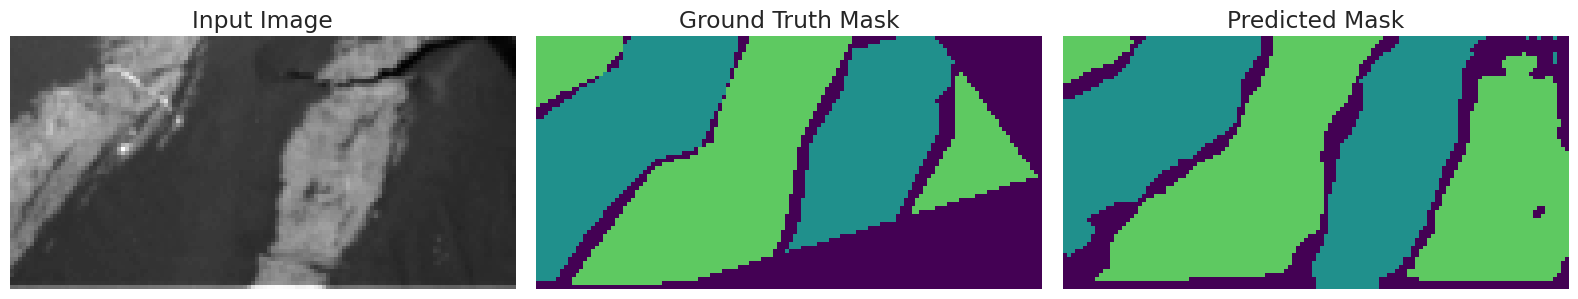

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9942 - loss: 0.0151 - mean_iou: 0.7865 - val_accuracy: 0.7605 - val_loss: 1.5441 - val_mean_iou: 0.4664 - learning_rate: 0.0010
Epoch 37/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9942 - loss: 0.0150 - mean_iou: 0.7854 - val_accuracy: 0.7592 - val_loss: 1.5377 - val_mean_iou: 0.4692 - learning_rate: 0.0010
Epoch 38/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9941 - loss: 0.0152 - mean_iou: 0.7876 - val_accuracy: 0.7596 - val_loss: 1.5954 - val_mean_iou: 0.4747 - learning_rate: 0.0010
Epoch 39/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9950 - loss: 0.0130 - mean_iou: 0.7879 - val_accuracy: 0.7574 - val_loss: 1.6633 - val_mean_iou: 0.4729 - learning_rate: 0.0010
Epoch 40/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9952 - loss: 0.0125 - mean_iou: 0.7888 - val_accuracy: 0.7554 - val_loss: 1.7060 - val_mean_iou: 0.4708 - learning_rate: 0.0010
Epoch 41/150
375/376 ━━

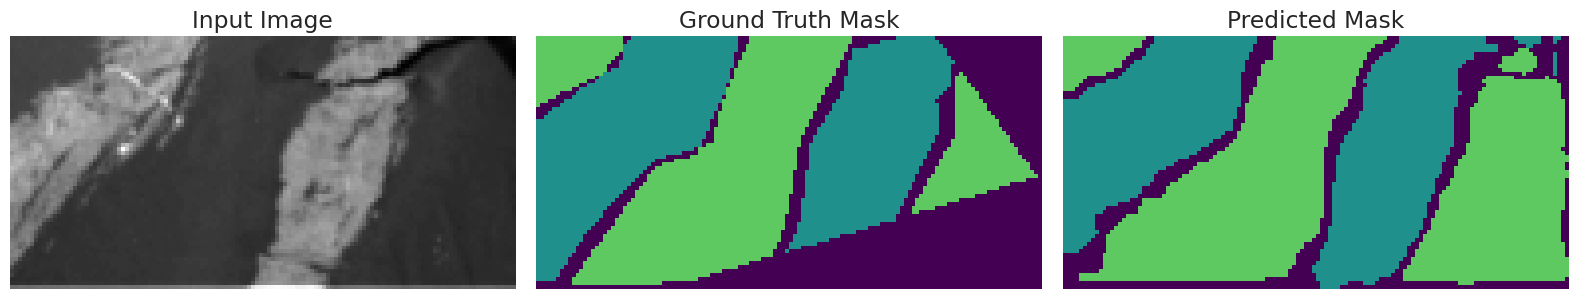

376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9953 - loss: 0.0122 - mean_iou: 0.7886 - val_accuracy: 0.7600 - val_loss: 1.6780 - val_mean_iou: 0.4700 - learning_rate: 0.0010
Epoch 42/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9637 - loss: 0.1069 - mean_iou: 0.7289 - val_accuracy: 0.7507 - val_loss: 1.0436 - val_mean_iou: 0.4564 - learning_rate: 0.0010
Epoch 43/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9838 - loss: 0.0443 - mean_iou: 0.7671 - val_accuracy: 0.7609 - val_loss: 1.3338 - val_mean_iou: 0.4691 - learning_rate: 0.0010
Epoch 44/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9951 - loss: 0.0128 - mean_iou: 0.7878 - val_accuracy: 0.7614 - val_loss: 1.5594 - val_mean_iou: 0.4689 - learning_rate: 0.0010
Epoch 45/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9966 - loss: 0.0089 - mean_iou: 0.7909 - val_accuracy: 0.7622 - val_loss: 1.6741 - val_mean_iou: 0.4697 - learning_rate: 0.0010
Epoch 46/150
375/376 ━━

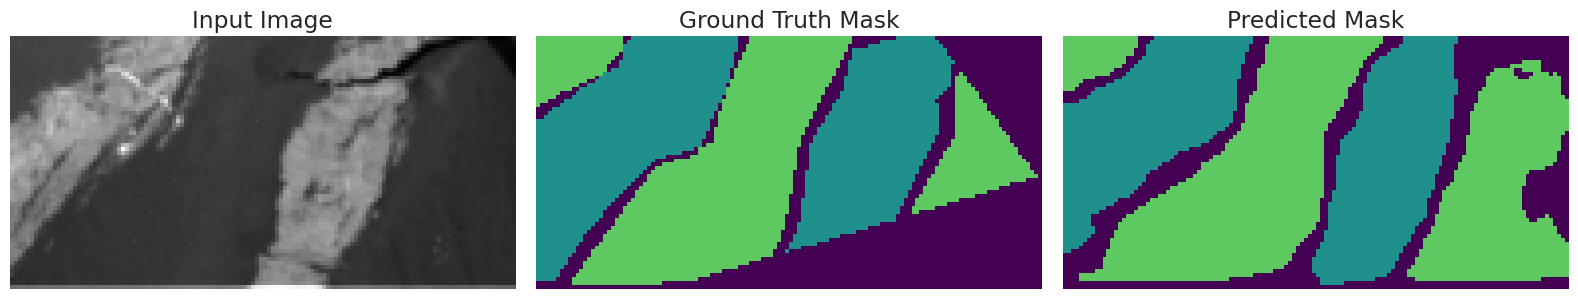

376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9972 - loss: 0.0074 - mean_iou: 0.7924 - val_accuracy: 0.7617 - val_loss: 1.7397 - val_mean_iou: 0.4694 - learning_rate: 0.0010
Epoch 47/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9973 - loss: 0.0072 - mean_iou: 0.7921 - val_accuracy: 0.7631 - val_loss: 1.7479 - val_mean_iou: 0.4704 - learning_rate: 0.0010
Epoch 48/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9970 - loss: 0.0079 - mean_iou: 0.7916 - val_accuracy: 0.7610 - val_loss: 1.7557 - val_mean_iou: 0.4700 - learning_rate: 0.0010
Epoch 49/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9969 - loss: 0.0081 - mean_iou: 0.7917 - val_accuracy: 0.7597 - val_loss: 1.7529 - val_mean_iou: 0.4691 - learning_rate: 0.0010
Epoch 50/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9971 - loss: 0.0076 - mean_iou: 0.7923 - val_accuracy: 0.7618 - val_loss: 1.7731 - val_mean_iou: 0.4733 - learning_rate: 0.0010
Epoch 51/150
375/376 ━━

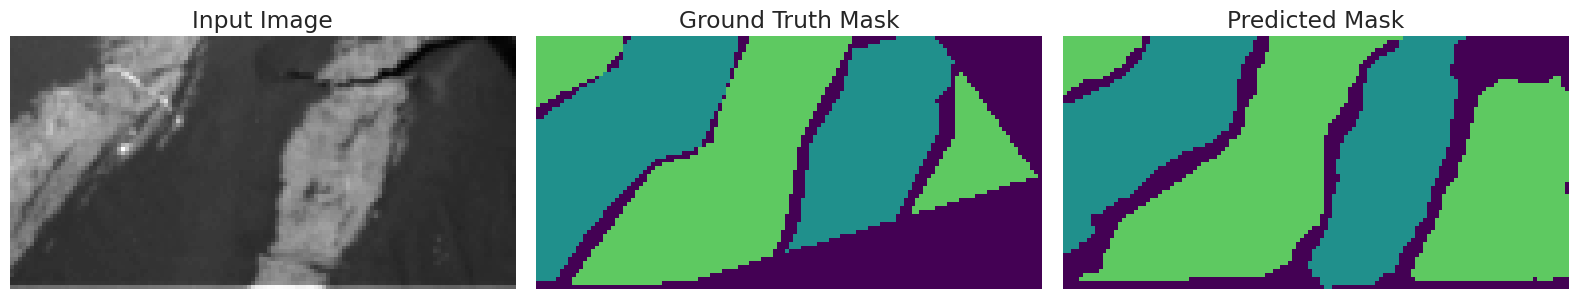

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9970 - loss: 0.0079 - mean_iou: 0.7931 - val_accuracy: 0.7627 - val_loss: 1.7872 - val_mean_iou: 0.4710 - learning_rate: 0.0010
Epoch 52/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9970 - loss: 0.0077 - mean_iou: 0.7931 - val_accuracy: 0.7601 - val_loss: 1.8322 - val_mean_iou: 0.4707 - learning_rate: 0.0010
Epoch 53/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9971 - loss: 0.0075 - mean_iou: 0.7918 - val_accuracy: 0.7551 - val_loss: 1.8772 - val_mean_iou: 0.4603 - learning_rate: 0.0010
Epoch 54/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9469 - loss: 0.1600 - mean_iou: 0.7005 - val_accuracy: 0.6527 - val_loss: 1.6540 - val_mean_iou: 0.3573 - learning_rate: 0.0010
Epoch 55/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9805 - loss: 0.0550 - mean_iou: 0.7683 - val_accuracy: 0.7615 - val_loss: 1.1759 - val_mean_iou: 0.4675 - learning_rate: 1.0000e-04
Epoch 56/150
375/37

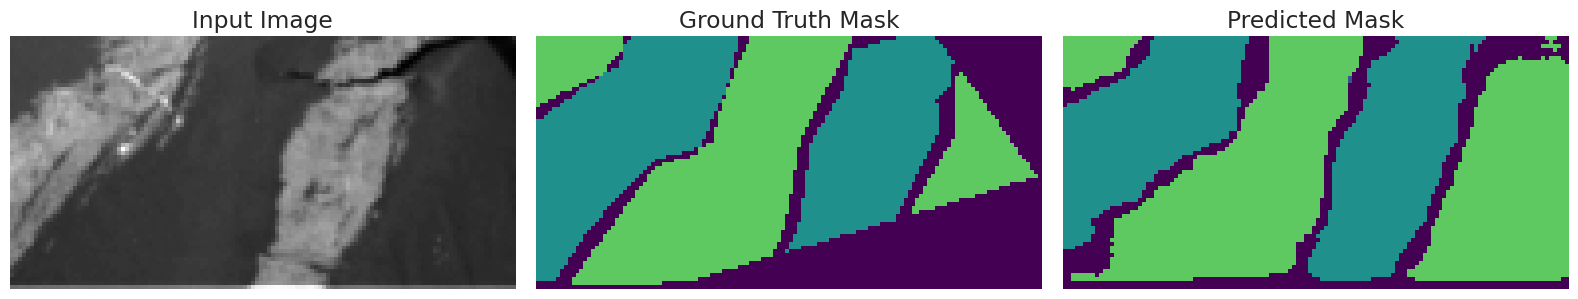

376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9910 - loss: 0.0237 - mean_iou: 0.7819 - val_accuracy: 0.7634 - val_loss: 1.3064 - val_mean_iou: 0.4693 - learning_rate: 1.0000e-04
Epoch 57/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9931 - loss: 0.0181 - mean_iou: 0.7856 - val_accuracy: 0.7643 - val_loss: 1.3864 - val_mean_iou: 0.4702 - learning_rate: 1.0000e-04
Epoch 58/150
370/376 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9944 - loss: 0.0147 - mean_iou: 0.7881

In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    callbacks=[earlystop, viz_callback, plateau],
    verbose=1,
    validation_data=(X_val, y_val)
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'baseline_'+str(final_val_meanIoU)+'.keras'

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"exploration_model_{timestep_str}.keras"
model.save(model_filename)
del model

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

In [ ]:
model = Attention_ResUNet(input_shape=input_shape, NUM_CLASSES=num_classes)

model.load_weights(model_filename)

print(f"Model weights loaded from {model_filename}")

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
def get_uncertain_regions(predictions, threshold=0.5):
    background_confidence = predictions[..., 0]  # Assuming 0 is background
    uncertain_mask = (background_confidence > threshold) & (background_confidence < 1 - threshold)
    return uncertain_mask

# Apply the function to your predictions
#uncertain_regions = get_uncertain_regions(preds)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```